# Portfolio analysis
This notebook introduces the concept of portfolio-level analyses. In this notebook, the results of the asset-level analysis are translated into firm-level results which are subsequently translated into portfolio-level results. The notebook is already in the original PRISK and it is used for an extension to tropical cyclones with CycloneEntitySim, CycloneBasinSim. Since we follow PRISK paper which prefers Merton model, we hide the empirical code from the original PRISK version and only present the Merton model result at the end.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson

sys.path.append(os.path.abspath(".."))
from prisk.utils import extract_firms, link_basins, merton_probability_of_default
from prisk.kernel import Kernel
from prisk.cyclone import CycloneEntitySim, CycloneBasinSim
from prisk.portfolio import Portfolio
from prisk.insurance import Insurance
sys.path.pop()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\Admin\Desktop\TCRiskIndiaMainMain\prisk\utils.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  continuous_curves = continuous_curves.merge(damage_curves, how="left", left_index=True, right_on="intensity")


In [23]:
insured = False
insurer_capital = 2e9
simulations = 500
random_seed = 0
sigma=0.2
sector = "coal" # the placeholder could be chosen as any element from ["coal","nuclear, "bioenergy", "oilgas"]

In [24]:
power = pd.read_excel(f"../Data/exceedence_{sector}_new.xlsx")
india_districts = "../shape_file/DISTRICT_BOUNDARY.shp"

The files containing the randomly generated samples can be generated using the notebooks found in the Exploratory analysis folder. Alternatively, they can be downloaded from the link in the package README.md file.

In [25]:
gaussian_random_numbers = pd.read_parquet(f"../Data/gaussian_random_numbers_cooccurrence_india_{sector}.parquet.gzip")
t_random_numbers = pd.read_parquet(f"../Data/t_random_numbers_cooccurrence_india_{sector}.parquet.gzip")
uniform_random_numbers = pd.read_parquet(f"../Data/uniform_random_numbers_india_{sector}.parquet.gzip")
complete_dependent_random_numbers = pd.read_parquet(f"../Data/complete_dependent_random_numbers_india_{sector}.parquet.gzip")

##### Extracting Agents
The P-RISK model is based on asset-level analyses that are subsequently translated into firm- and portfolio-level impacts. To extract the firms from the Global Energy Monitor database, we use a utility function. If this approach is applied on a different dataset, then the extract_firms function needs to be replaced.

We limit the analysis to a single country.

In [26]:
financial_data = pd.read_excel("https://kuleuven-prisk.s3.eu-central-1.amazonaws.com/Indian_firms.xlsx")
median_ratio  = financial_data["Leverage Ratio"].median()
financial_data["Leverage Ratio"].fillna(median_ratio, inplace=True)
leverage_ratios = {firm: leverage for firm, leverage in zip(financial_data["clean"], financial_data["Leverage Ratio"])}

In [27]:
leverage_ratios

{'Asia Commercial Bank': 0.9013,
 'Ares Strategic Mining Inc': 0.4254,
 'Aarti Industries': 0.45,
 'Abhijeet Group': 0.6012500000000001,
 'Adani Power Ltd': 0.5327,
 'Adhunik Power And Natural Resources': 0.6012500000000001,
 'Aditya Birla Chemicals India': 0.7582,
 'Ambuja Cements': 0.3651,
 'Andhra Paper': 0.2273,
 'Andhra Pradesh Gas Power Co Ltd': 0.5803,
 'Anrak Aluminium': 0.6012500000000001,
 'Apraava Energy': 0.2803,
 'Aravali Power Company': 0.6012500000000001,
 'Arcelor Mittal': 0.403,
 'Arkay Energy Rameswarm Ltd': 0.6012500000000001,
 'Assam Power Generation Corp Ltd': 0.4808,
 'Vedanta': 0.6396,
 'Atul Ltd': 0.3551,
 'Bla Power': 0.6012500000000001,
 'Bmm Ispat': 0.6012500000000001,
 'Ballarpur Industries': 0.3752,
 'Balrampur Chini Mills Ltd': 0.4505,
 'Bharatiya Nabhikiya Vidyut Nigam Ltd': 0.6012500000000001,
 'Bhartiya Rail Bijlee': 0.6961,
 'Gujarat State Petronet Ltd': 0.1325,
 'Bhubaneshwar Power': 0.4331,
 'Bhushan Power & Steel': 0.4667,
 'Bihar State Power Holdin

In [28]:
india = power.copy().reset_index(drop=True)
firms = extract_firms(india, leverage_ratios=leverage_ratios)

##### Portfolio construction
The portfolio consists of the firms linked to the assets located in India. We assume an equal weighted portfolio:

In [29]:
portfolio = Portfolio("Indian power assets")
nav = 1
for firm in firms:
    portfolio.add_position(firm, nav/(len(firms)*firm.npv))                    

In [32]:
portfolio.assets

,asset,firm,firm_exposure,asset_ownership,exposure,value
0,Adani Godda power station,Asia Commercial Bank,8.453561e-12,1.0,8.453561e-12,1.688397e+09
1,Aditya Aluminium power station,Asia Commercial Bank,8.453561e-12,1.0,8.453561e-12,3.165745e+08
2,Amravati Thermal Power Project,Adani Power Ltd,5.003666e-12,1.0,5.003666e-12,5.698341e+08
3,Angul power station,Adani Power Ltd,5.003666e-12,1.0,5.003666e-12,1.266298e+09
4,Angul Steel power station,Adani Power Ltd,5.003666e-12,1.0,5.003666e-12,2.849171e+08
...,...,...,...,...,...,...
88,Vallur Thermal Power Plant,The Singareni Collieries,1.606177e-11,1.0,1.606177e-11,1.055248e+09
89,Visakhapatnam Sarda power station,The West Bengal Power Development,9.560575e-11,1.0,9.560575e-11,1.772817e+08
90,Vizag Thermal Power Plant,Tulsyan Nec,1.544401e-11,1.0,1.544401e-11,1.097458e+09
91,Yadadri power station,Uttar Pradesh Rajya Vidyut Utpadan Nigam,5.019302e-12,1.0,5.019302e-12,1.688397e+09


## Conduct simulation
The prisk simulations are still performed at the asset-level but due to the set-up with python classes, the results can easily be analysed at the portfolio-level. In each notebook, we perform multiple versions of the prisk framework that differentiate in the dependency modelling framework that was used. The five frameworks are:
1. **Completely independent events**: each asset has independent tropical cyclone events that occur.
2. **Basin-level dependence**: tropical cyclones are simulated at the basin-level. Whenever a tropical cyclone occurs in a basin, all assets located inside that basin are affected. The tropical cyclones between basins are assumed to be independent.
3. **Complete dependence**: the dependency of tropical cyclones between basins are modelled using three copula functions: (1) gaussian copula, (2) the t-copula, and (3) the vine copula.

At the beginning of each of the model cells, we set the random seed. This ensures that the results are (1) completely reproducible, (2) perfectly compareable across different notebook versions (robustness checks), and (3) perfectly comparable across different dependency modelling approaches.

#### 1. Complete independence

In [31]:
np.random.seed(0)

merton_independence = []
for i in tqdm(range(simulations)):
    assets = india.asset.to_list().copy()
    insurer = Insurance("Insurance company", capital=insurer_capital, subscribers=[])
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        # The cyclone entity sim simulates cyclones at the asset-level without considering other asset events
        CycloneEntitySim(asset).simulate(time_horizon=25, kernel=kernel)
    kernel.run(time_horizon=25, verbose=0) # time horizon: 25 years, the remainder will be included in TV

    merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
                    + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)   
                for firm in firms]

    merton_independence.append(merton_pds)
    for asset in assets:
        asset.reset() # Reset the assets to their initial state

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:47<00:00, 10.60it/s]


#### 2. Basin-Level dependence
First, we start up by linking the asset locations to a specific basin. The geopandas package is used.

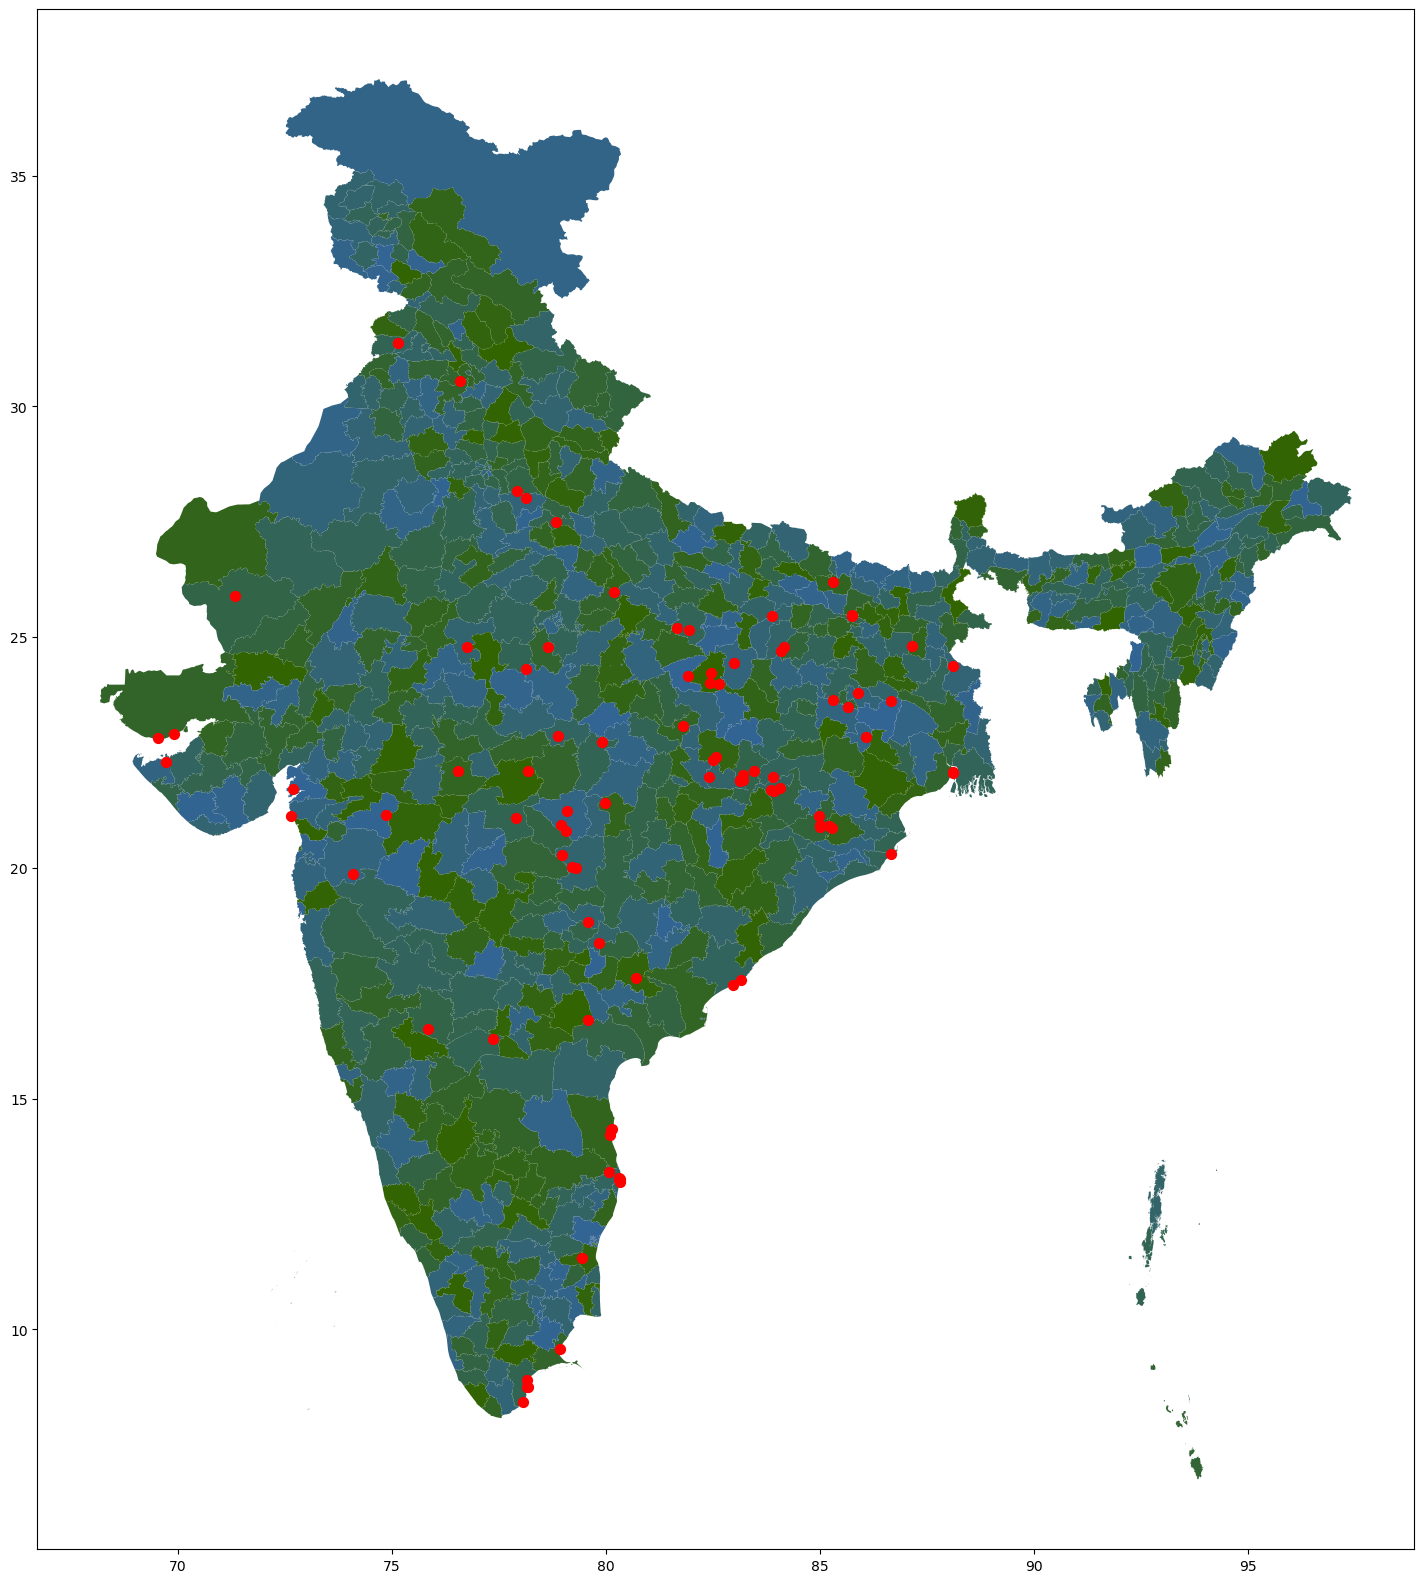

In [34]:
india, basins = link_basins(india, india_districts, visualize=True, save=True);
name_to_id = india.set_index("Plant / Project name")["ID"]

Once the basins are obtained, we simulate events at the basin level and incorporate it into the simulation:

In [35]:
def events_df(random_numbers, years=25):
    return_periods = [5, 10, 25, 50, 100, 200, 500, 1000]
    events = pd.DataFrame()
    for return_period in return_periods:
        simulated_data = random_numbers.sample(years).reset_index(drop=True)
        simulated_data = simulated_data.apply(lambda x: poisson.ppf(x, 1/return_period)).reset_index()
        simulated_data = simulated_data.replace(0, pd.NA).melt(id_vars="index").dropna()
        if simulated_data.empty:
            continue
        simulated_data.loc[:, "return_period"] = return_period
        events = pd.concat([events, simulated_data])
    events.columns = ["year", "basin", "events", "return_period"]
    events.basin = events.basin.astype(str)
    return events

Now we generate random portfolio values:

In [36]:
np.random.seed(0)

merton_independent_basins = []

portfolio_values_independent_basins = []
for i in tqdm(range(simulations)):
    events = events_df(uniform_random_numbers, years=25)
    events["basin"] = events["basin"].map(name_to_id)
    assets = india.asset.to_list()
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        basin = india[india.asset == asset].ID.iloc[0]
        events_asset = events[events.basin==basin]
        CycloneBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)

    merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
                    + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)   
                for firm in firms]

    merton_independent_basins.append(merton_pds)
    for asset in assets:
        asset.reset()

100%|██████████| 500/500 [05:42<00:00,  1.46it/s]


#### 3. Dependent Basins
In the previous simulation, the basins were assumed to be indepenent. Now, the dependencies between basins are taken into account using different copulas. We have a function to generate these events:

##### 3.1. Gaussian copula

In [ ]:
np.random.seed(0)

merton_gaussian = []

portfolio_values_gaussian_basins = []
for i in tqdm(range(simulations)):
    events = events_df(random_numbers=gaussian_random_numbers, years=25)
    events["basin"] = events["basin"].map(name_to_id)
    assets = india.asset.to_list()
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        basin = india[india.asset == asset].ID.iloc[0]
        events_asset = events[events.basin==basin]
        CycloneBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)

    merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
                    + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)   
                for firm in firms]

    merton_gaussian.append(merton_pds)
    for asset in assets:
        asset.reset()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [12:20<00:00,  1.48s/it]


##### 3.1. T-copula

In [ ]:
np.random.seed(0)

merton_t = []

portfolio_values_gaussian_basins = []
for i in tqdm(range(simulations)):
    events = events_df(random_numbers=t_random_numbers, years=25)
    events["basin"] = events["basin"].map(name_to_id)
    assets = india.asset.to_list()
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        basin = india[india.asset == asset].ID.iloc[0]
        events_asset = events[events.basin==basin]
        CycloneBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)

    merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
                    + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)   
                for firm in firms]

    merton_t.append(merton_pds)
    for asset in assets:
        asset.reset()

100%|██████████| 500/500 [12:31<00:00,  1.50s/it]


#### 4. Complete Dependence
In complete dependence, all assets are hit at the same time.

In [ ]:
np.random.seed(0)

merton_dependent = []

for i in tqdm(range(simulations)):
    events = events_df(random_numbers=complete_dependent_random_numbers, years=25)
    events["basin"] = events["basin"].map(name_to_id)
    assets = india.asset.to_list()
    insurer = Insurance("Insurance company", capital=insurer_capital)
    kernel = Kernel(assets=assets, insurers=[insurer])
    for asset in assets:
        if insured:
            asset.add_insurer(insurer)
        basin = india[india.asset == asset].ID.iloc[0]
        events_asset = events[events.basin==basin]
        CycloneBasinSim(asset, events_asset).simulate(kernel=kernel)
    kernel.run(time_horizon=25, verbose=0)

    merton_pds = [-merton_probability_of_default(V=firm.base_value, sigma_V=sigma, D=firm.original_liabilities)
                    + merton_probability_of_default(V=firm.npv, sigma_V=sigma, D=firm.original_liabilities)   
                for firm in firms]

    merton_dependent.append(merton_pds)
    for asset in assets:
        asset.reset()


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [10:11<00:00,  1.22s/it]


## Summary of results

In [22]:
merton_avg_independent = [np.nanmean(mert) for mert in merton_independence]

merton_avg_basin = [np.nanmean(mert) for mert in merton_independent_basins]

merton_avg_gaussian = [np.nanmean(mert) for mert in merton_gaussian]

merton_avg_t = [np.nanmean(mert) for mert in merton_t]

merton_avg_dependent = [np.nanmean(mert) for mert in merton_dependent]

merton_q95_independent = np.quantile(merton_avg_independent, 0.95)

merton_q99_independent = np.quantile(merton_avg_independent, 0.99)

merton_q95_basin = np.quantile(merton_avg_basin, 0.95)

merton_q99_basin = np.quantile(merton_avg_basin, 0.99)

merton_q95_gaussian = np.quantile(merton_avg_gaussian, 0.95)

merton_q99_gaussian = np.quantile(merton_avg_gaussian, 0.99)

merton_q95_t = np.quantile(merton_avg_t, 0.95)

merton_q99_t = np.quantile(merton_avg_t, 0.99)

merton_q95_dependent = np.quantile(merton_avg_dependent, 0.95)

merton_q99_dependent = np.quantile(merton_avg_dependent, 0.99)

merton_q50_independent = np.quantile(merton_avg_independent, 0.5)

merton_average_independent = np.mean(merton_avg_independent)

merton_q50_basin = np.quantile(merton_avg_basin, 0.5)

merton_average_basin = np.mean(merton_avg_basin)

merton_q50_gaussian = np.quantile(merton_avg_gaussian, 0.5)

merton_average_gaussian = np.mean(merton_avg_gaussian)

merton_q50_t = np.quantile(merton_avg_t, 0.5)

merton_average_t = np.mean(merton_avg_t)

merton_q50_dependent = np.quantile(merton_avg_dependent, 0.5)

merton_average_dependent = np.mean(merton_avg_dependent)

merton_results = pd.DataFrame({
    "Average Impact": [merton_average_independent, merton_average_basin, merton_average_gaussian, merton_average_t, merton_average_dependent],
    "Median Impact": [merton_q50_independent, merton_q50_basin, merton_q50_gaussian, merton_q50_t, merton_q50_dependent],
    "95th percentile": [merton_q95_independent, merton_q95_basin, merton_q95_gaussian, merton_q95_t, merton_q95_dependent],
    "99th percentile": [merton_q99_independent, merton_q99_basin, merton_q99_gaussian, merton_q99_t, merton_q99_dependent],
}, index=["Complete independence", "Basin-level independence", 
          "Gaussian copula", "T copula", "Complete dependence"]) * 1000


In [23]:
merton_results

,Average Impact,Median Impact,95th percentile,99th percentile
Complete independence,17.900959,16.712427,35.907048,46.058744
Basin-level independence,45.777322,44.037243,82.780273,93.917890
Gaussian copula,42.621804,35.756084,100.303686,133.401192
T copula,40.720786,34.508801,97.360979,121.337708
Complete dependence,43.452590,8.289328,200.442856,246.151184
